## **Importing dataset and necessary libraries**



In [2]:
import pandas as pd
import re
from sklearn.cluster import KMeans
from scipy.cluster.vq import kmeans, vq
from matplotlib.lines import Line2D
import numpy as np
import seaborn as sns
sns.set_context('paper')
sns.set(font_scale=1)
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [3]:
data = pd.read_csv('books.csv', error_bad_lines=False)

b'Skipping line 3350: expected 12 fields, saw 13\nSkipping line 4704: expected 12 fields, saw 13\nSkipping line 5879: expected 12 fields, saw 13\nSkipping line 8981: expected 12 fields, saw 13\n'


In [4]:
df = (pd.DataFrame(data)).set_index("bookID")

## **Getting an overview of the dataset**

In [5]:
print("Dataset contains {} rows and {} columns".format(df.shape[0], df.shape[1]))

Dataset contains 11123 rows and 11 columns


In [6]:
df.sample(5)

,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
bookID,,,,,,,,,,,
11511,L'Échiquier du mal,Dan Simmons,3.90,2207254410,9782207254417,fre,999,63,7,6/8/2003,Denoël
13664,Catwings (Catwings #1),Ursula K. Le Guin/S.D. Schindler,4.09,0439551897,9780439551892,eng,40,6598,600,5/1/2003,Orchard Books
10971,Hydra's Ring (Outlanders #39),James Axler,3.88,0373638523,9780373638529,eng,348,25,2,11/1/2006,Gold Eagle
7847,Moby-Dick,Herman Melville/Nathaniel Philbrick,3.50,0142000086,9780142000083,en-US,625,1022,165,9/1/2001,Penguin Books
42855,Great Speeches by African Americans: Frederick...,James Daley/Barack Obama/Martin Luther King Jr.,4.30,0486447618,9780486447612,eng,160,230,21,4/28/2006,Dover Publications


## **Cleaning**


As we do not need the columns **isbn** and **isbn-13** for the data analysis, therefore we drop these columns.

In [7]:
df.drop(['isbn','isbn13'],axis = 1,inplace=True)

We notice that the column **num_pages** has unintended white space in its name. To maintain uniformity, we rename it to a more suitable name **total_pages**.

In [8]:
df.rename(columns={'  num_pages':'total_pages'},inplace=True)

Next, we check if the dataset contains any rows with **null** values.

In [9]:
df.isnull().sum()

title                 0
authors               0
average_rating        0
language_code         0
total_pages           0
ratings_count         0
text_reviews_count    0
publication_date      0
publisher             0
dtype: int64

On observation, we notice that in the author column, **J.K. Rowling's** illustrator **Mary GrandPré** is also mentioned in the author's list. Removing Mary GrandPré from the column:

In [10]:
df.replace(to_replace = 'J.K. Rowling/Mary GrandPré', value= 'J.K Rowling',inplace = True)

We notice that inorder to represent multiple authors, the **"/"** sign is used. This sign does not indicate co-authorship, instead it can be misunderstood to represent **pen names or literary doubles** for the author. To reduce confusion we replace **"/"** with **","** as the delimiter of choice.

In [11]:
df['authors'] = df['authors'].str.replace('/',',')

Next, we remove unintended whitespaces in some author's names. 

In [12]:
df = df.replace('\s+', ' ', regex=True)

# **Exploratory Data Analysis**

## **Part 1 - EDA on Titles**



**1. Which are the Top 20 books with the most occurences in the list**.<br>
We find out which books have been published various times under the same name since its first edition. Also, we include any supplementary material published for these books. These books have clearly been popular over generations, are considered essential reads, referenced to by multiple authors, and have stood the test of time.

c:\users\waleed\appdata\local\programs\python\python37\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


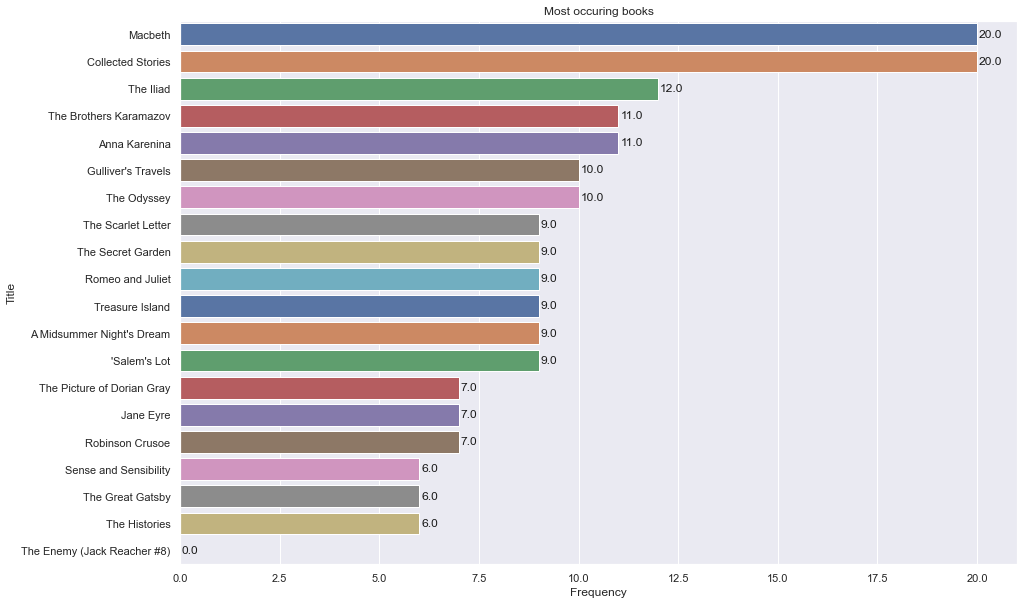

In [13]:
titles = df['title']
n = 20
most_occur = titles.value_counts()[:n]
most_occur_names = most_occur.index

freq = list()
for book in most_occur_names:
    freq.append((len(titles[titles.str.contains(book)])))

df_most_occur = {'title': most_occur_names, 'freq': freq}
df_most_occur = pd.DataFrame(df_most_occur).sort_values(by=['freq'], ascending = False)

plt.figure(figsize =(15,10))
ax = sns.barplot(data = df_most_occur, x="freq", y = "title", palette = 'deep')
for i in ax.patches:
    ax.text(i.get_width() + .05, i.get_y() + 0.5, str(i.get_width()), fontsize = 12, color = 'k')
plt.title("Most occuring books")
plt.xlabel("Frequency")
plt.ylabel("Title")
plt.show()

According to the results, **Macbeth, Collected Stories, The Illiad, and The Brothers Karamzov** are the **top 3 books** to have been published multiple times and written about by other authors.

**2. What is the distribution of books for all languages?**<br>
Which languages are preferred by authors - which language are most books written/published in?

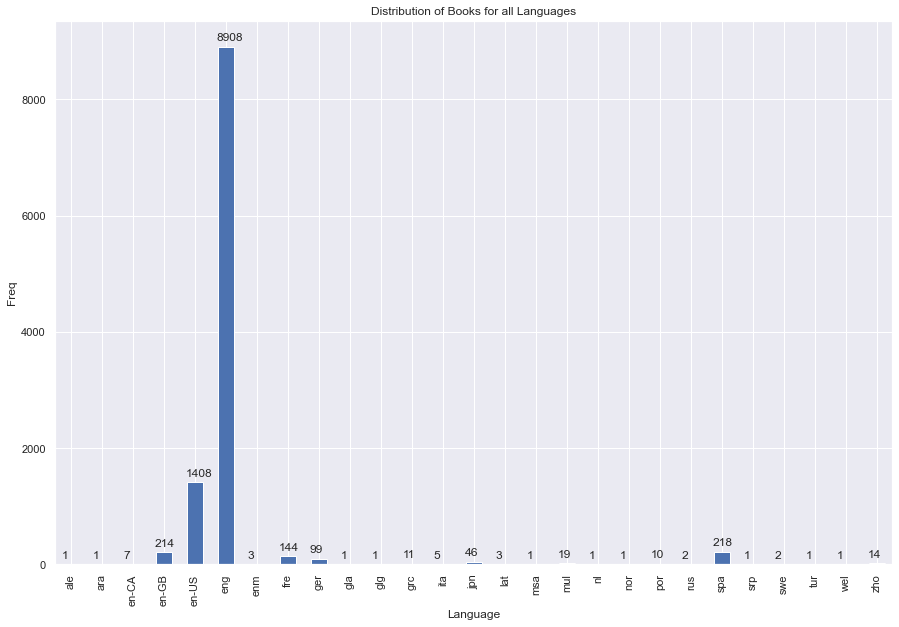

In [14]:
plt.figure(figsize =(15,10))
language_count = df.groupby('language_code')['title'].count()
ax = language_count.plot.bar()
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()-0.05, p.get_height()+100))
plt.title("Distribution of Books for all Languages")
plt.xlabel("Language")
plt.ylabel("Freq")
plt.show()

The results show that **English**, and its **US** and **Great Britain** variants are the most preffered by authors. 

### **Exploring the relationship between Average Ratings and Rating Count**

**3. Plotting the Distribution of Average Ratings**<br>

<Figure size 1080x1800 with 0 Axes>

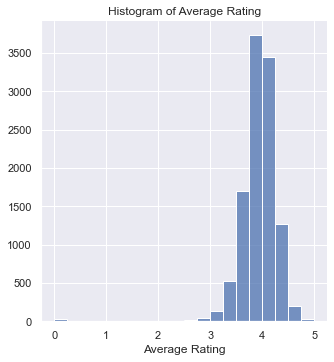

In [15]:
plt.figure(figsize=(15,25))
ax = sns.displot(df['average_rating'].astype(float), bins = 20)
plt.title("Histogram of Average Rating")
plt.xlabel("Average Rating")
plt.ylabel("")
plt.show()

We can see from the distribution above, most of the average ratings are centered around the **4.0** mark. From the results, we can interpret that readers are likely to enjoy a book they decide to read. 

**4. Which books have received the most critiques? - Top 20 Most Voted Books (ratings_count)** <br>
In this section, we find the books that have been rated the most i.e. vote count, irrespective of the rating received.

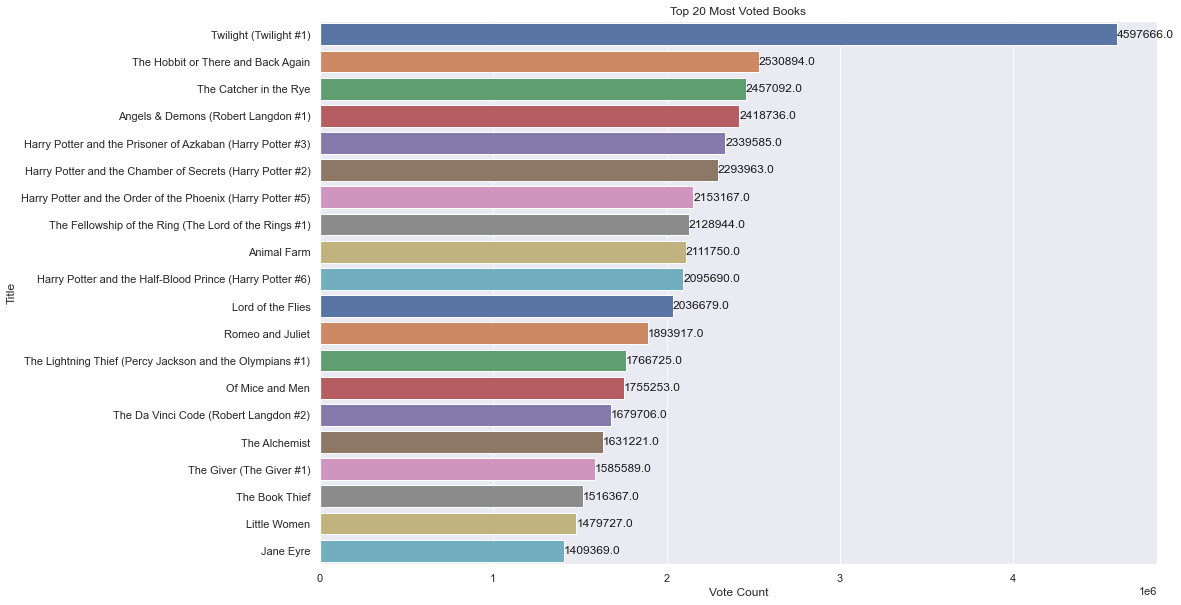

In [16]:
most_rated = df.sort_values('ratings_count', ascending = False).head(20).set_index('title')
plt.figure(figsize=(15,10))
ax = sns.barplot(x = most_rated['ratings_count'], y = most_rated.index, palette = 'deep')
for i in ax.patches:
    ax.text(i.get_width() + .05, i.get_y() + 0.5, str(i.get_width()), fontsize = 12, color = 'k')
plt.title("Top 20 Most Voted Books")
plt.xlabel("Vote Count")
plt.ylabel("Title")
plt.show()

The books with the highest vote count are:<br>
**1. Twilight with more than 4 million votes.**<br>
**2. The Hobbit or There and Back Again with more than 2 million votes.**<br>
**3. The Catcher in the Rye with more than 2 million votes.**<br>

Moreover, we see a trend in the results. A lot of books in the list belong to a series of books, mostly fiction. This gives us the notion that once readers begin a series, they are likely to read subsequent releases.

Furthermore, we also observe that the earliest books in a series are the most voted, and the number of readers/voters go down with subsequent releases, showing that the first books are the most critiqued and the reader's lose interest as the series progresses.<br>

**5. Which books have highest rating? Given that they have atleast a million votes - Top 20 Highly Rated Books (average_rating)**<br>
Here, we extract the books that have the highest average rating on the condition that they have been rated by atleast a million users.

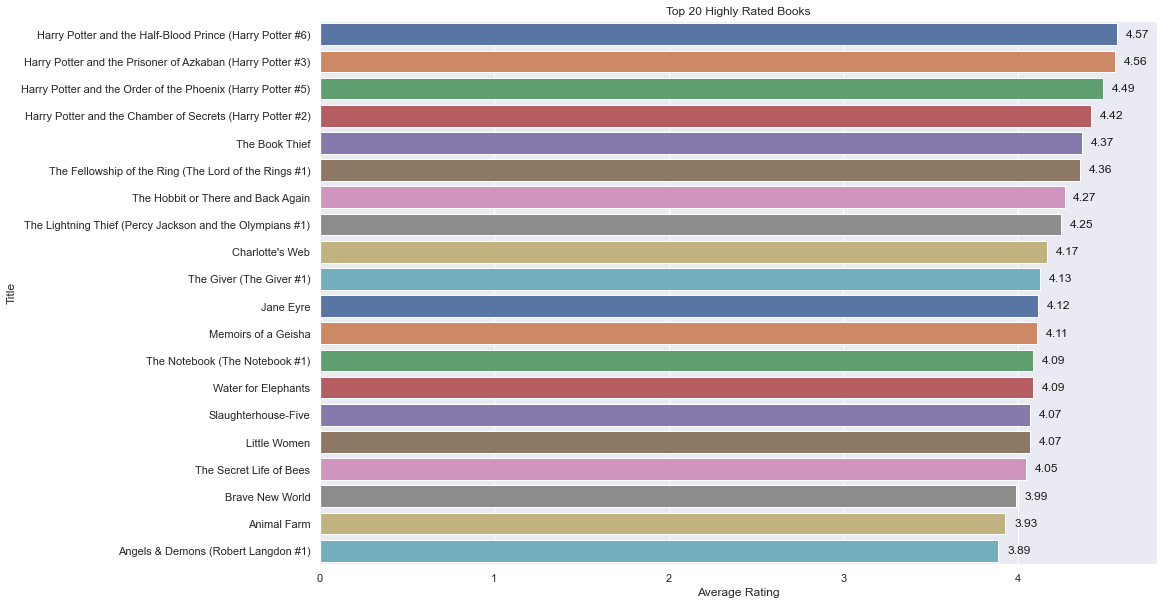

In [17]:
threshold = 1000000
top_books = (df[df['ratings_count'] > threshold])
top_books = top_books.sort_values(by='average_rating', ascending=False).head(20)
top_books = top_books.set_index('title')

plt.figure(figsize=(15,10))
ax = sns.barplot(data = top_books, x = 'average_rating', y = top_books.index, palette = 'deep')
for i in ax.patches:
    ax.text(i.get_width() + .05, i.get_y() + 0.5, str(i.get_width()), fontsize = 12, color = 'k')
plt.title("Top 20 Highly Rated Books")
plt.xlabel("Average Rating")
plt.ylabel("Title")
plt.show()

**The Harry Potter Series tops the chart, securing the first four positions with average ratings ranging from 4.42 - 4.57**

The results hold importance as the books have been voted on by atleast a million readers - a large sample size, meaning that the books are popular and well-liked by a large number of readers.

**6. Scatter Plot - Relationship between Average Ratings and Rating Count.**<br>

<Figure size 1080x720 with 0 Axes>

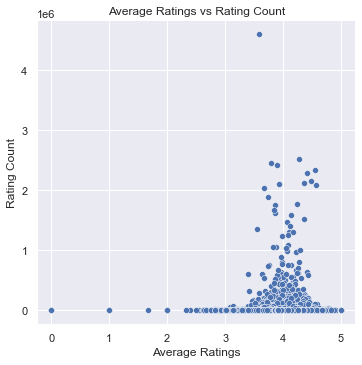

In [18]:
plt.figure(figsize=(15,10))
ax = sns.relplot(data=df, y="ratings_count", x="average_rating")
plt.title("Average Ratings vs Rating Count")
plt.xlabel("Average Ratings")
plt.ylabel("Rating Count")
plt.show()

From the scatterplot, we find that books with over a million votes are rare, yet these are the books whose average ratings are to be considered credible and statistically significant.

**7. Books that have recieved the most votes yet aren't rated high - Top Voted but not Top Rated.**<br>
Here, we find the books that have a high number of votes but are not highly rated. This indicates that such books are popular and a large number of people have read them yet critiqued negatively and have not been well recieved.


In [19]:
most_rated_set = set(most_rated.index)
top_books_set = set(top_books.index)
result = most_rated_set - top_books_set
result = pd.DataFrame(result, columns = ['Top Voted but not Top Rated'])
result

,Top Voted but not Top Rated
0,Romeo and Juliet
1,Of Mice and Men
2,The Alchemist
3,The Da Vinci Code (Robert Langdon #2)
4,Lord of the Flies
5,The Catcher in the Rye
6,Twilight (Twilight #1)


**8. Books that have recieved high ratings but have a relatively low vote count - Top Rated but not Top Voted.**<br>
Here, we find the books that have a high rating but do not have a significant vote count. This indicates that the high rating of these books is not statistically significant due to low vote count.

In [20]:
result = top_books_set - most_rated_set
result = pd.DataFrame(result, columns = ['Top Rated but not Top Voted'])
result

,Top Rated but not Top Voted
0,Slaughterhouse-Five
1,The Secret Life of Bees
2,Charlotte's Web
3,Water for Elephants
4,Brave New World
5,The Notebook (The Notebook #1)
6,Memoirs of a Geisha


**9. What are the most common/recurring words in book titles that have an average rating of atleast 4.0.**

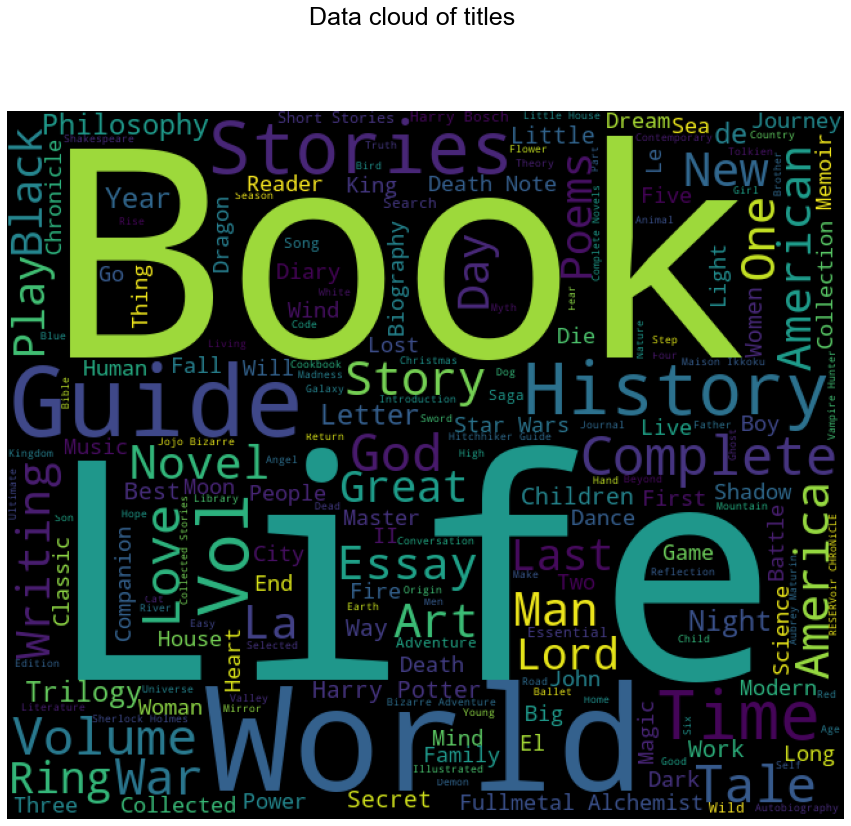

In [21]:
atleast_four = df[df['average_rating'] >= 4.0]
title_value = atleast_four.title.unique()
plt.subplots(figsize=(15,15))
wordcloud = WordCloud(
                          background_color='#000',
                          width=650,
                          height=550,
                          stopwords=STOPWORDS,
                         ).generate(" ".join(title_value))
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('graph.png')

plt.figtext(.5,.91,'Data cloud of titles', color='black', fontsize=25, ha='center')
plt.show()

## **Part 2 - EDA on Authors**

**10. Top 20 Frequently Published Authors** <br>
In this section, we find the authors that have been published the most i.e. authors with the most books.

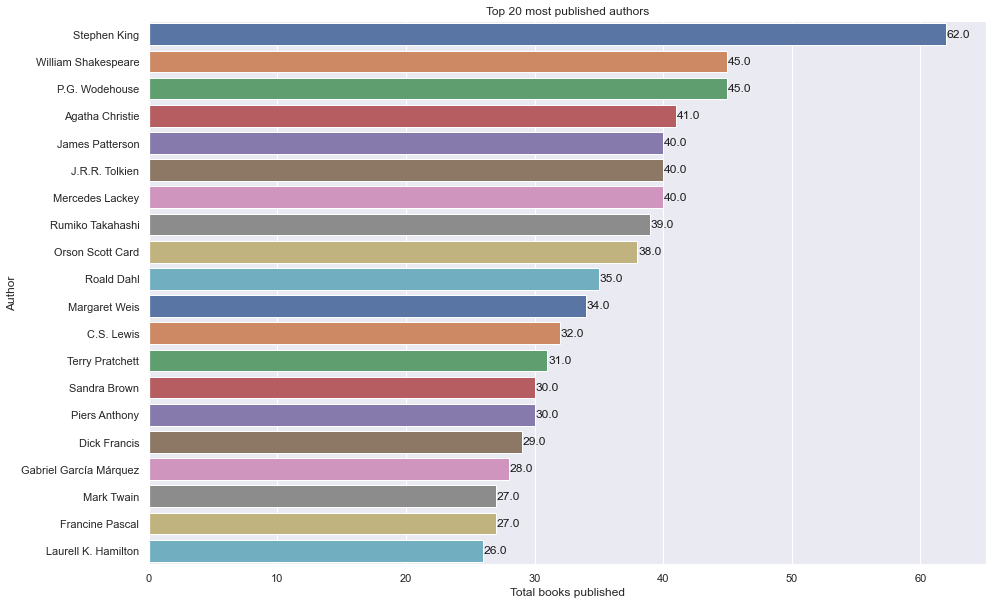

In [22]:
df_unique = df.copy()
author_list = list()
for author in df_unique['authors']:
    if "," in author:
        temp = author.split(',')
        author_list.append(temp[0])
    else:
        author_list.append(author)
        
df_unique['single_author'] = author_list

total_book = df_unique.groupby(by=['single_author']).agg({'title': ['nunique']})
total_book.columns = ['total_book']
total_book.reset_index(inplace=True)
total_book = (total_book.sort_values(by=['total_book'], ascending=False)).head(20)




plt.figure(figsize=(15,10))
ax = sns.barplot(x = total_book['total_book'], y = total_book['single_author'], palette='deep')
for i in ax.patches:
    ax.text(i.get_width() + .05, i.get_y() + 0.5, str(i.get_width()), fontsize = 12, color = 'k')
plt.title("Top 20 most published authors")
plt.xlabel("Total books published")
plt.ylabel("Author")
plt.show()

**Stephen King is the most published authors with 62 books published. William Shakespeare and P.G.Wodehouse are second with 45 books published.**

We can see from the above plot that Stephen King has the most number of books in the list - although a lot of them might be just various publications for the same book, this does not get rid of the fact that his books are well recieved. 

From the names in the list, we can infer that most of the authors have either been writing for a long periods, releasing numerous books regularly, or are authors who are well liked, or their books are hyped and have a cult following in a niche genres. 

**11. Top 20 Frequently Published Authors - Weighted by Average Rating >= 4.0**<br>
Here, we see the results in **9** with a different perspective. Instead of considering all the books when finding most published authors, we only count those books which have achieved an **average rating of atleast 4**. 


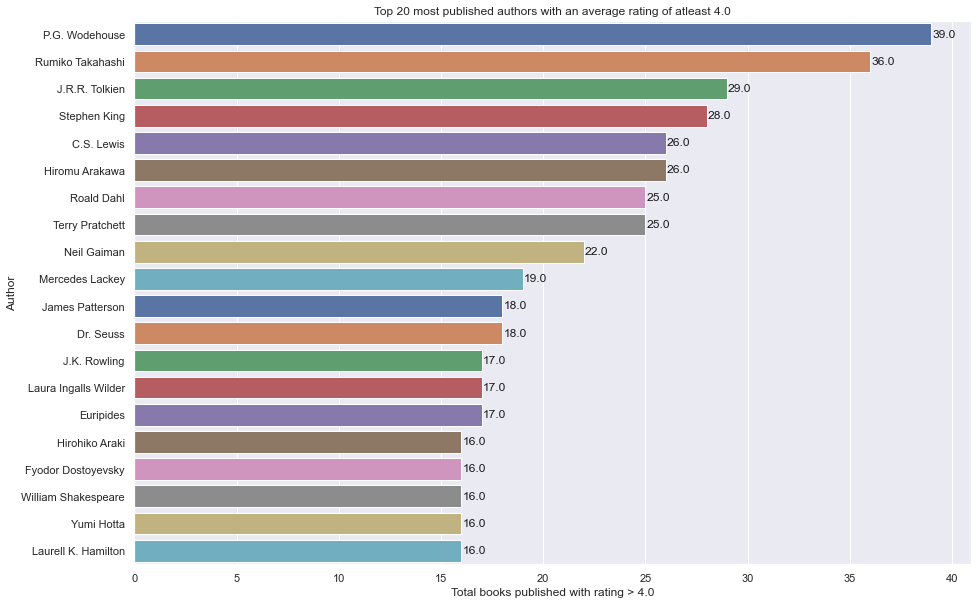

In [23]:
df_high_rating = df.copy()
df_high_rating = df_high_rating[df_high_rating['average_rating']>=4.0]
author_list = list()
for author in df_high_rating['authors']:
    if "," in author:
        temp = author.split(',')
        author_list.append(temp[0])
    else:
        author_list.append(author)
        
df_high_rating['single_author'] = author_list

avg_rating = df_high_rating.groupby('single_author')['average_rating'].mean()
avg_rating.columns = ['avg_rating']

total_book = df_high_rating.groupby(by=['single_author']).agg({'title': ['nunique']})
total_book.columns = ['total_book']
total_book = (total_book.sort_values(by=['total_book'], ascending=False)).head(20)

df_high_rating = total_book.merge(avg_rating, on='single_author', how='left')

plt.figure(figsize=(15,10))
ax = sns.barplot(x = df_high_rating['total_book'], y = df_high_rating.index, palette='deep')
for i in ax.patches:
    ax.text(i.get_width() + .05, i.get_y() + 0.5, str(i.get_width()), fontsize = 12, color = 'k')

plt.title("Top 20 most published authors with an average rating of atleast 4.0")
plt.xlabel("Total books published with rating > 4.0")
plt.ylabel("Author")
plt.show()

**P.G.Wodehouse** has published the most books while maintaining an **average rating of at least 4.0** across his books.

Here, we see a lot of the same authors we saw in the results of **Part 4** and a lot of new authors as well. Most of the authors in the previous result retain their position in the Top 20. 

**Authors at the lower end of this result haven't published as much as those in the previous result, but their books are well recieved and maintain an average rating of atleast 4.0.**



**12. Average Rating of Authors with atleast a million votes.**<br>
Here, we find the Top 20 authors based on the average ratings their books have recieved over time. 


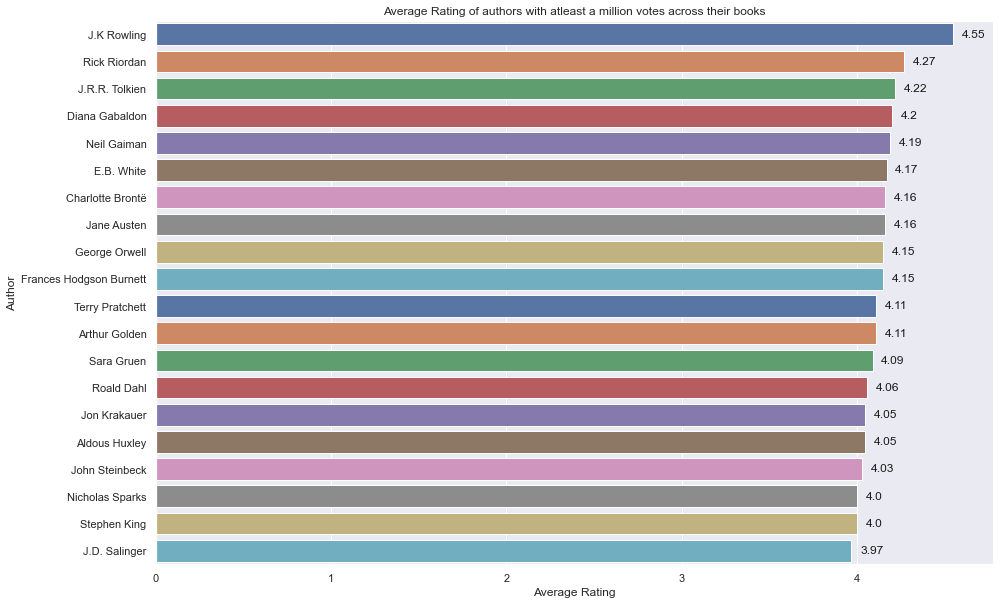

In [24]:
df_author = df.copy()
author_list = list()
for author in df_author['authors']:
    if "," in author:
        temp = author.split(',')
        author_list.append(temp[0])
    else:
        author_list.append(author)
        
df_author['single_author'] = author_list
df_avg_rating = df_author.groupby('single_author')['average_rating'].mean().round(2)
df_vote_count = df_author.groupby('single_author')['ratings_count'].sum()
df_avg_rating = df_avg_rating.to_frame()
df_vote_count = df_vote_count.to_frame()
df_author = df_avg_rating.merge(df_vote_count, on='single_author', how='left')

df_author = df_author[df_author['ratings_count']>1000000]
df_author = (df_author.sort_values(by=['average_rating'], ascending=False)).head(20)

plt.figure(figsize=(15,10))
ax = sns.barplot(x = df_author['average_rating'], y = df_author.index, palette='deep')
for i in ax.patches:
    ax.text(i.get_width() + .05, i.get_y() + 0.5, str(i.get_width()), fontsize = 12, color = 'k')

plt.title("Average Rating of authors with atleast a million votes across their books")
plt.xlabel("Average Rating")
plt.ylabel("Author")
plt.show()

**13. Performance of an author over time.**<br>
Here, we take the top 4 most published authors and assess their performance/average ratings over their career.

We'll test out the performance of these four authors over time:<br>

**Stephen King**

**P.G. Wodehouse**

**William Shakespeare**

**Agatha Christie**

In [25]:
df_author = df.copy()
author_list = list()
for author in df_author['authors']:
    if "," in author:
        temp = author.split(',')
        author_list.append(temp[0])
    else:
        author_list.append(author)
        
df_author['single_author'] = author_list
publication_year = list()
for date in df_author['publication_date']:
  publication_year.append(date[-4:])

df_author['publication_year'] = publication_year

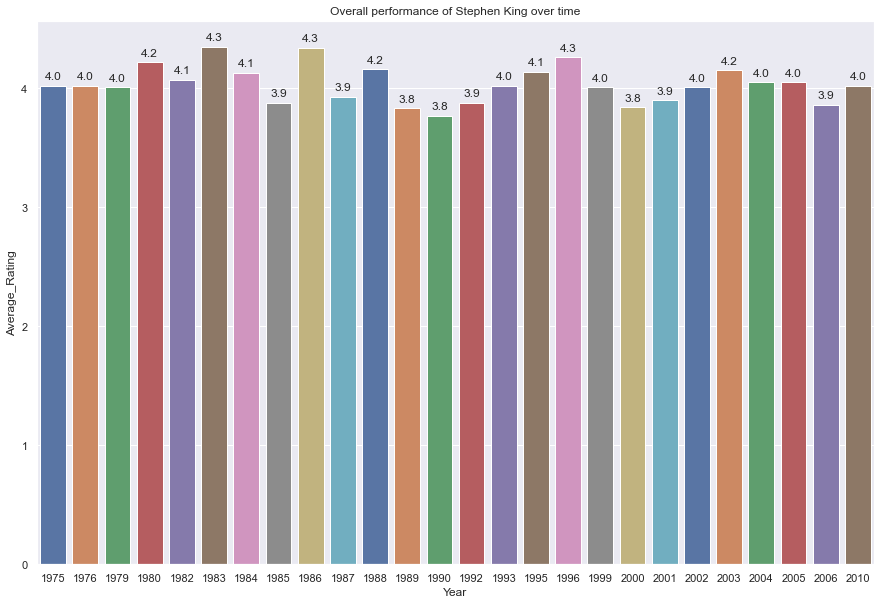

In [26]:
stephen_king = df_author.loc[(df_author['single_author'] == 'Stephen King'), ('publication_year', 'average_rating')]
stephen_king = (stephen_king.groupby('publication_year')['average_rating'].mean().round(2)).to_frame()
stephen_king.columns = ['average_rating']

plt.figure(figsize=(15,10))
ax = sns.barplot(x = stephen_king.index, y = stephen_king['average_rating'], palette='deep')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.title("Overall performance of Stephen King over time")
plt.xlabel("Year")
plt.ylabel("Average_Rating")
plt.show()

We can notice from the plot that **Stephen King** was at his best in 1983, 1986, and 1996, hitting the peak of his career in these three years. Stephen's perforamance usually dips at the start of a decade, dipping to 3.8 in both 1990 and 2000. His performance usually increases a few years into a decade.

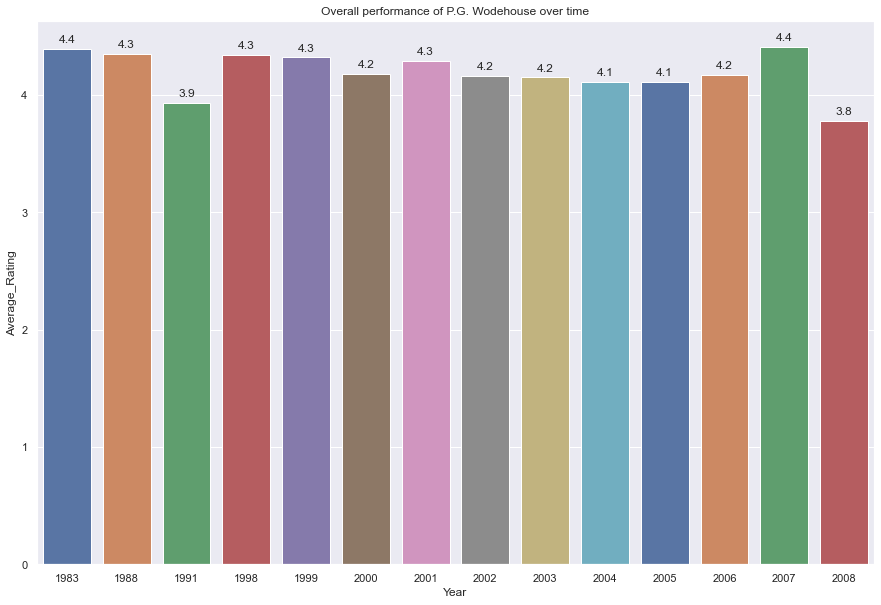

In [27]:
pg_wodehouse = df_author.loc[(df_author['single_author'] == 'P.G. Wodehouse'), ('publication_year', 'average_rating')]
pg_wodehouse = (pg_wodehouse.groupby('publication_year')['average_rating'].mean().round(2)).to_frame()
pg_wodehouse.columns = ['average_rating']

plt.figure(figsize=(15,10))
ax = sns.barplot(x = pg_wodehouse.index, y = pg_wodehouse['average_rating'], palette='deep')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.title("Overall performance of P.G. Wodehouse over time")
plt.xlabel("Year")
plt.ylabel("Average_Rating")
plt.show()

**P.G. Wodehouse** usually maintained a high rating of atleast 4 over his career, reaching the peak in 2007, his performance dipping below 4.0 only in 1991 and 2008 respectively.

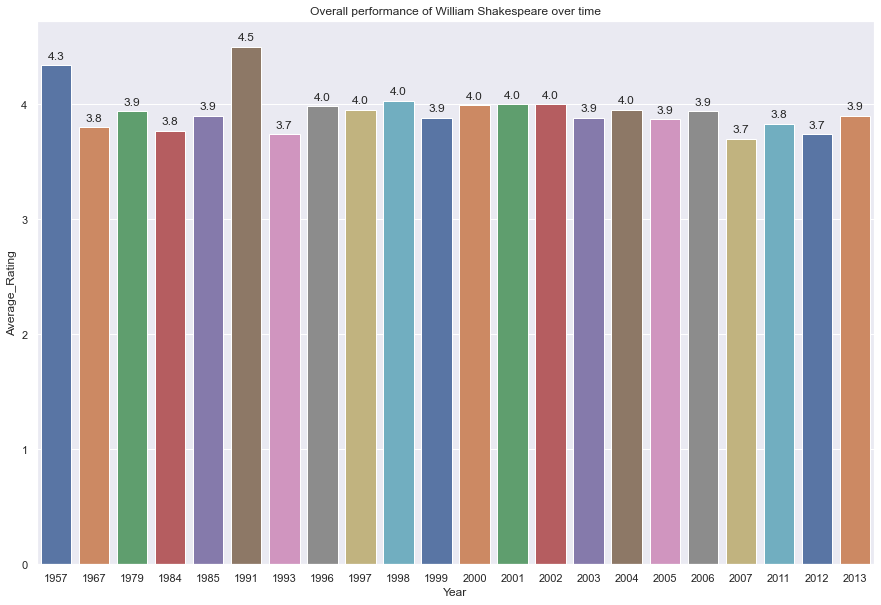

In [28]:
william_shakespeare = df_author.loc[(df_author['single_author'] == 'William Shakespeare'), ('publication_year', 'average_rating')]
william_shakespeare = (william_shakespeare.groupby('publication_year')['average_rating'].mean().round(2)).to_frame()
william_shakespeare.columns = ['average_rating']

plt.figure(figsize=(15,10))
ax = sns.barplot(x = william_shakespeare.index, y = william_shakespeare['average_rating'], palette='deep')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.title("Overall performance of William Shakespeare over time")
plt.xlabel("Year")
plt.ylabel("Average_Rating")
plt.show()

We notice that **William Shakespeare** had the lowest rating among the four authors for a few years. However, he also acheived the highest rating among the 4 in 1991.

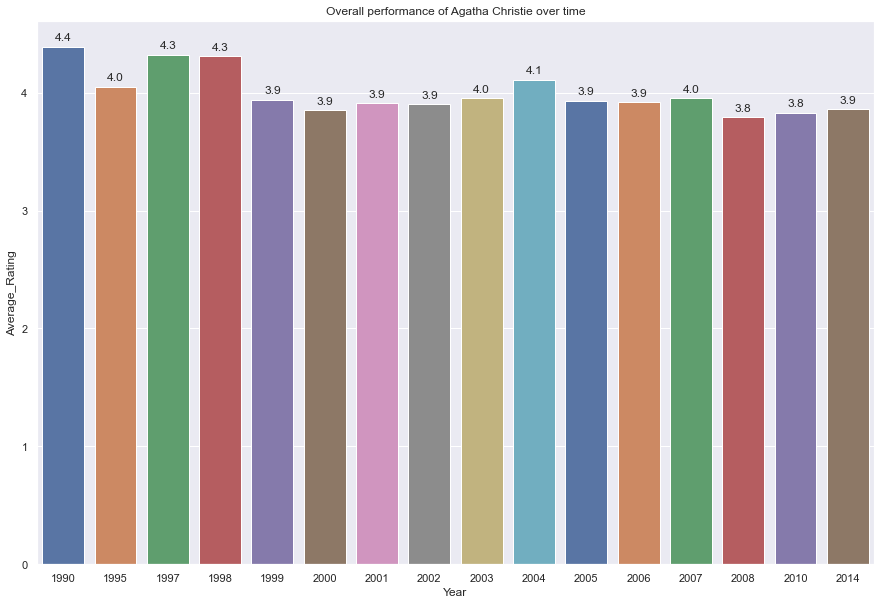

In [29]:
agatha_christie = df_author.loc[(df_author['single_author'] == 'Agatha Christie'), ('publication_year', 'average_rating')]
agatha_christie = (agatha_christie.groupby('publication_year')['average_rating'].mean().round(2)).to_frame()
agatha_christie.columns = ['average_rating']

plt.figure(figsize=(15,10))
ax = sns.barplot(x = agatha_christie.index, y = agatha_christie['average_rating'], palette='deep')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.title("Overall performance of Agatha Christie over time")
plt.xlabel("Year")
plt.ylabel("Average_Rating")
plt.show()

**Agatha Christie** has entered the 4.0 mark a lot fewer times than others, yet her average rating/performance remains consistent, never dipping lower than usual.

## **Part 3 - Exploring Further Relationships - Setting up for Machine Learning**

**14. Is there a relationship between the number of text reviews and average rating.**<br>


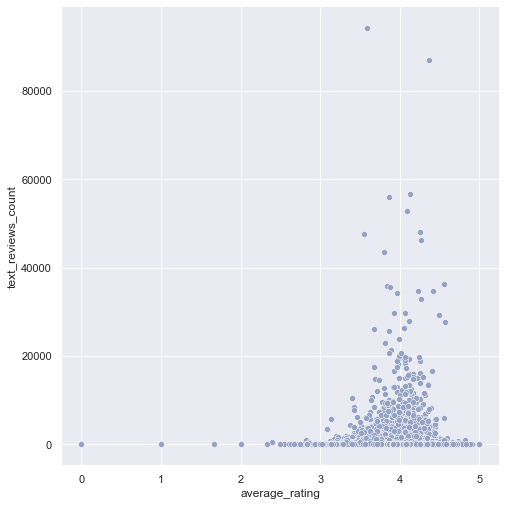

In [30]:
ax = sns.relplot(data=df, x="average_rating", y="text_reviews_count", color = '#95a3c3', sizes=(100, 200), height=7, marker='o')

We can observe from the plot that most of the ratings for the books lie around the 3-4 mark. However, most of the text reviews are very low in number, clustered around the 5000 mark. Let's limit our view to 5000 text review counts in order to get a closer look: 

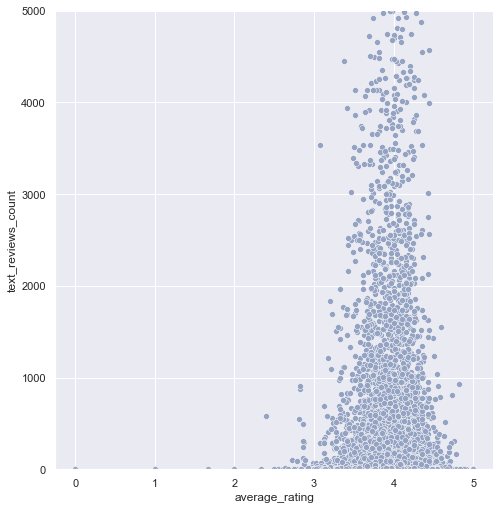

In [31]:
ax = sns.relplot(data=df, x="average_rating", y="text_reviews_count", color = '#95a3c3', sizes=(100, 200), height=7, marker='o')
ax.set(ylim=(0, 5000))

On a closer look, we see that text review count is densely clustered under the 1000 mark, leaving us with not enough points to establish a relationship. Moreover, however limited the review counts are, most of them are for books with an average rating of around 4.0. 

The results point to two conclusions, either the reviews are not legit or a book has a high chance to be well liked by readers.




**15. Is there a relationship between the number of pages and average rating.**<br>


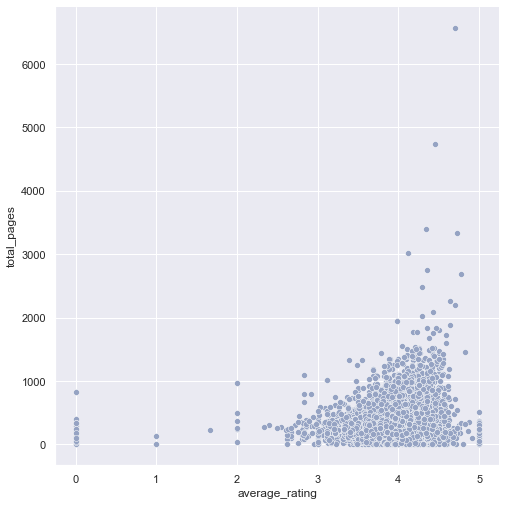

In [32]:
ax = sns.relplot(data=df, x="average_rating", y="total_pages", color = '#95a3c3', sizes=(100, 200), height=7, marker='o')

We can observe from the plot that most books are under a 1000 pages, the presence of outliers above 100 pages, renders the graph uninterpretable. Let's limit our view to 1000 pages in order to get a closer look: 

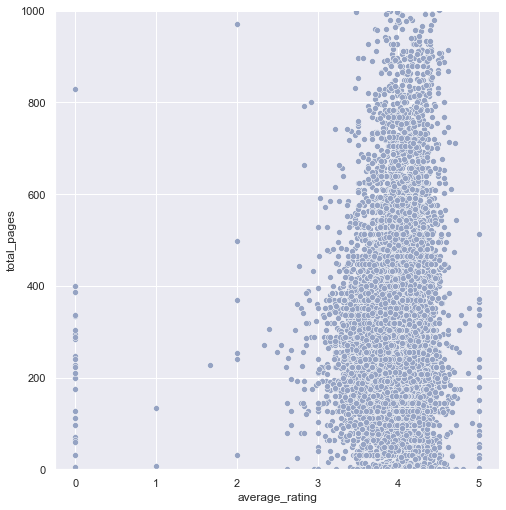

In [33]:
ax = sns.relplot(data=df, x="average_rating", y="total_pages", color = '#95a3c3', sizes=(100, 200), height=7, marker='o')
ax.set(ylim=(0, 1000))

From the given plot, we observe that the **highest ratings 4.5-5.0** usually are for books with the **page range of 200-400**. We can infer that people prefer books with a moderate number of pages.

**16. Is there a relationship between the number of ratings and average rating.**<br>


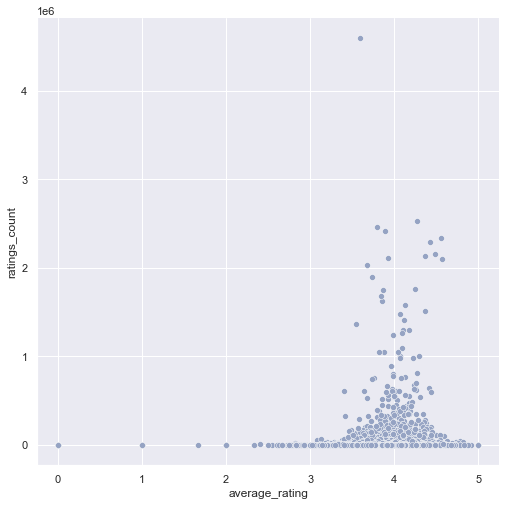

In [34]:
ax = sns.relplot(data=df, y="ratings_count", x="average_rating", color = '#95a3c3', sizes=(100, 200), height=7, marker='o')

Due to outliers present, we limit our view to 2 million ratings to get a closer look:

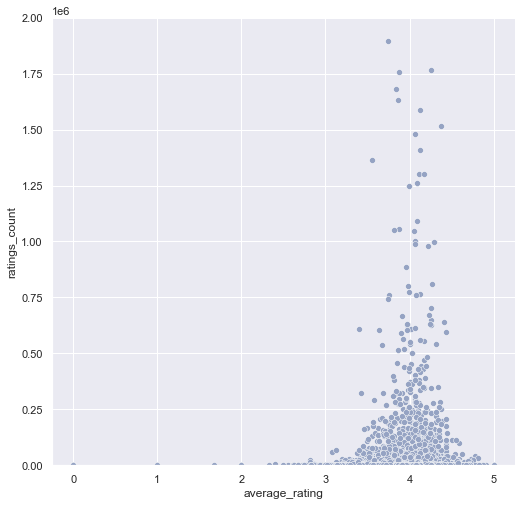

In [35]:
ax = sns.relplot(data=df, y="ratings_count", x="average_rating", color = '#95a3c3', sizes=(100, 200), height=7, marker='o')
ax.set(ylim=(0, 2000000))

From the results, we observe that most of the books have a rating count **below 250000**. **Moreover as the rating count increases, average rating gets closer to 4.0**

# **Machine Learning - K-Means**

**Here we attempt to find a relationship or groups between the rating count and average rating value.**<br>

In [51]:
dataset1 = df[['average_rating', 'ratings_count']]
data = np.asarray([np.asarray(dataset1['average_rating']), np.asarray(dataset1['ratings_count'])]).T

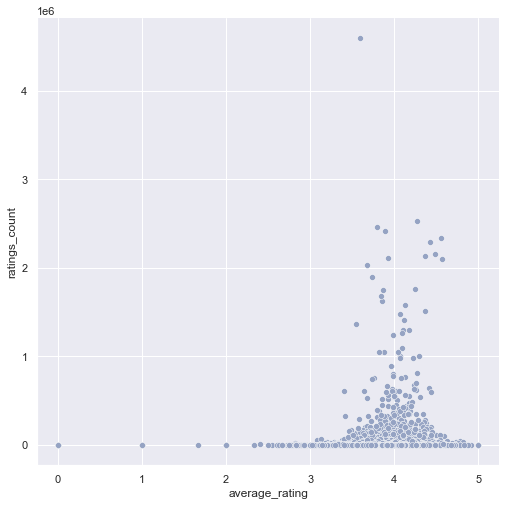

In [52]:
ax = sns.relplot(data=dataset1, y="ratings_count", x="average_rating", color = '#95a3c3', sizes=(100, 200), height=7, marker='o')

We'll use the Elbow Curve method to determine the number of clusters present in the data

In [53]:
Sum_of_squared_distances = []
K = range(1,30)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data)
    Sum_of_squared_distances.append(km.inertia_)

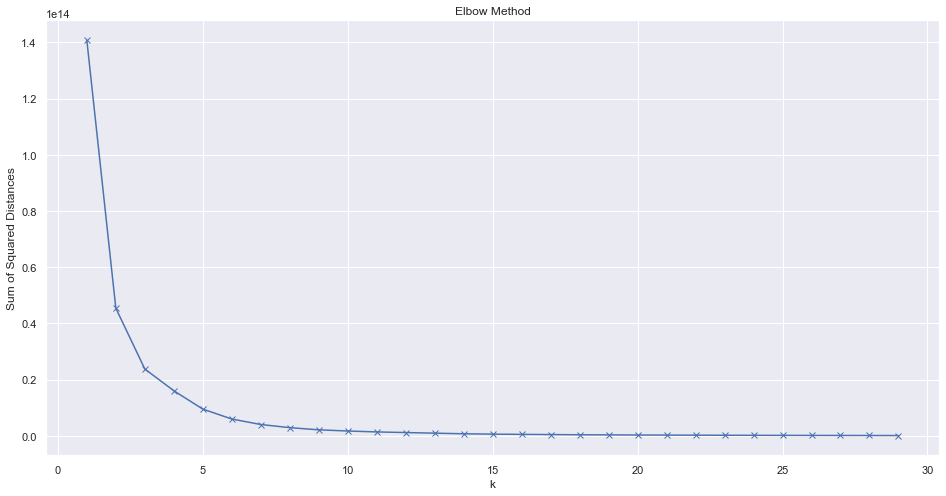

In [54]:
plt.figure(figsize=(16,8))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method')
plt.show()

<B>The plot above shows that the elbow lies at K=5. The dataset is therefore divided into 5 clusters.<B>

In [55]:
kmeans = KMeans(n_clusters=5, init ='k-means++', max_iter=300, n_init=10,random_state=0,tol=0.0001 )
y_means = kmeans.fit_predict(data)

In [56]:
Clusters = kmeans.cluster_centers_
Clusters

array([[3.93124444e+00, 6.03512129e+03],
       [4.11684211e+00, 1.96233547e+06],
       [4.03102041e+00, 7.67526735e+05],
       [4.01796296e+00, 2.03721115e+05],
       [3.59000000e+00, 4.59766600e+06]])

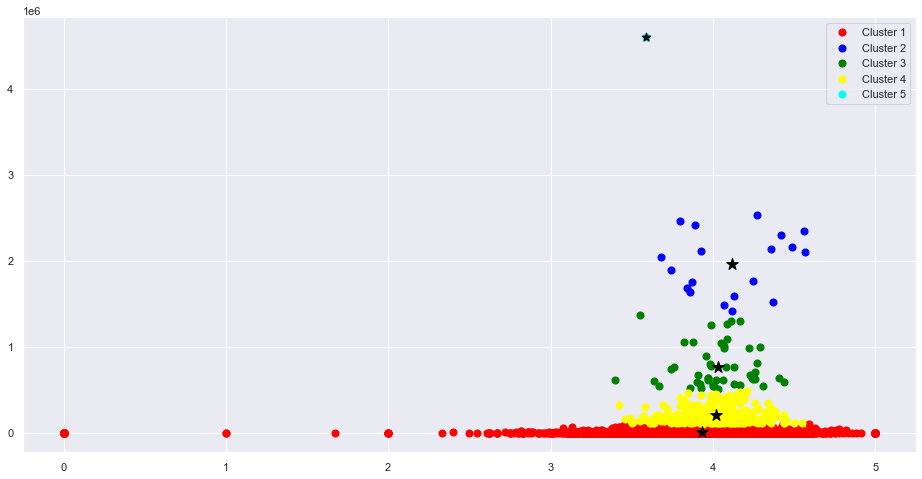

In [57]:
plt.figure(figsize=(16,8))
plt.scatter(data[y_means==0, 0], data[y_means==0, 1], s=50, c='red', label ='Cluster 1')
plt.scatter(data[y_means==1, 0], data[y_means==1, 1], s=50, c='blue', label ='Cluster 2')
plt.scatter(data[y_means==2, 0], data[y_means==2, 1], s=50, c='green', label ='Cluster 3')
plt.scatter(data[y_means==3, 0], data[y_means==3, 1], s=50, c='yellow', label ='Cluster 4')
plt.scatter(data[y_means==4, 0], data[y_means==4, 1], s=50, c='cyan', label ='Cluster 5')
plt.scatter(Clusters[0][0],Clusters[0][1], marker='*', s=150, color='black')
plt.scatter(Clusters[1][0],Clusters[1][1], marker='*', s=150, color='black')
plt.scatter(Clusters[2][0],Clusters[2][1], marker='*', s=150, color='black')
plt.scatter(Clusters[3][0],Clusters[3][1], marker='*', s=150, color='black')
plt.scatter(Clusters[4][0],Clusters[4][1], marker='*', s=80, color='black')
plt.legend(('Cluster 1','Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5'), numpoints = 1, loc = 0, )
plt.show()

**We can observe that the dataset can be binned into 5 clusters, the stars indicate the centre of our clusters. However we also observe that the presence of outliers skew our results.**<br>

### **KMeans with Optimisation**

**Next, we find and remove the outliers.**<br>

In [58]:
dataset1.idxmax()

average_rating     2034
ratings_count     41865
dtype: int64

<h4>Removing outliers<h4>

In [59]:
dataset1.drop(2034, inplace = True)
dataset1.drop(41865, inplace = True)



c:\users\waleed\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [61]:
newdata = np.asarray([np.asarray(dataset1['average_rating']), np.asarray(dataset1['ratings_count'])]).T
newdata

array([[4.570000e+00, 2.095690e+06],
       [4.490000e+00, 2.153167e+06],
       [4.420000e+00, 6.333000e+03],
       ...,
       [3.960000e+00, 8.200000e+02],
       [3.720000e+00, 7.690000e+02],
       [3.910000e+00, 1.130000e+02]])

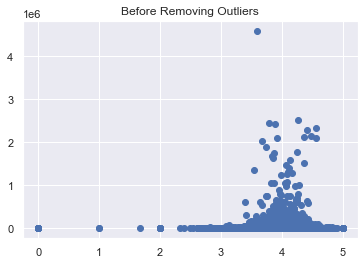

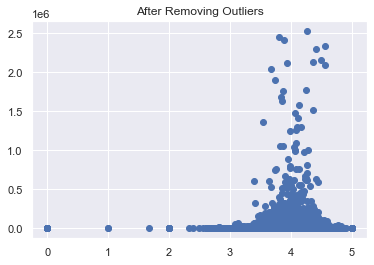

In [65]:
plot2 = plt.figure(2)
plt.title(label="Before Removing Outliers")
ax1=plt.scatter(data[:,0], data[:,1])


plot1 = plt.figure(1)
plt.title(label="After Removing Outliers")
plt.scatter(newdata[:,0], newdata[:,1])

In [63]:
kmeans2 = KMeans(n_clusters=5, init ='k-means++', max_iter=300, n_init=10,random_state=0,tol=0.0001 )
y_means = kmeans2.fit_predict(newdata)
clusters = kmeans2.cluster_centers_

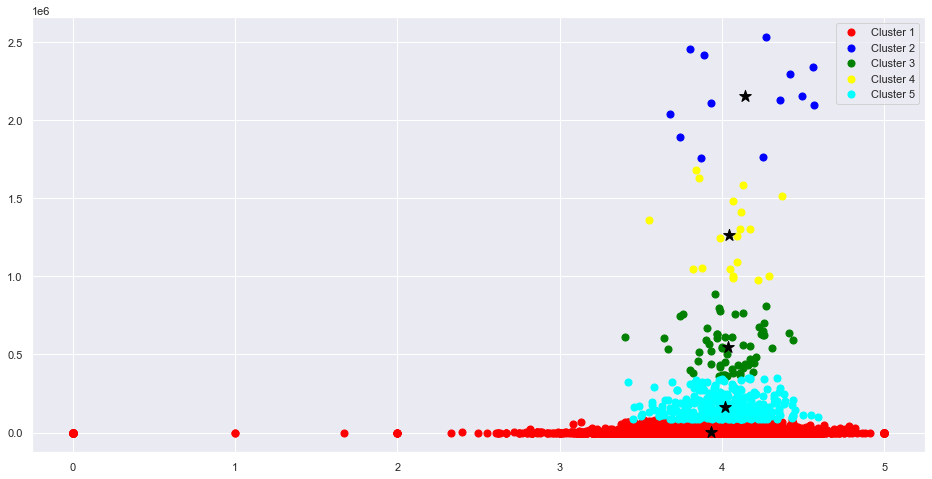

In [64]:

plt.figure(figsize=(16,8))
plt.scatter(newdata[y_means==0, 0], newdata[y_means==0, 1], s=50, c='red', label ='Cluster 1')
plt.scatter(newdata[y_means==1, 0], newdata[y_means==1, 1], s=50, c='blue', label ='Cluster 2')
plt.scatter(newdata[y_means==2, 0], newdata[y_means==2, 1], s=50, c='green', label ='Cluster 3')
plt.scatter(newdata[y_means==3, 0], newdata[y_means==3, 1], s=50, c='yellow', label ='Cluster 4')
plt.scatter(newdata[y_means==4, 0], newdata[y_means==4, 1], s=50, c='cyan', label ='Cluster 5')
plt.scatter(clusters[0][0],clusters[0][1], marker='*', s=150, color='black')
plt.scatter(clusters[1][0],clusters[1][1], marker='*', s=150, color='black')
plt.scatter(clusters[2][0],clusters[2][1], marker='*', s=150, color='black')
plt.scatter(clusters[3][0],clusters[3][1], marker='*', s=150, color='black')
plt.scatter(clusters[4][0],clusters[4][1], marker='*', s=150, color='black')
plt.legend(('Cluster 1','Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5'), numpoints = 1, loc = 0, )
plt.show()

**Now that we have optimized the clusters, we can form inferences.**<br>

**As the rating count increases, the clusters become sparser but less volatile, meaning that if a book has a high rating count, we can predict its rating with higher accuracy and a higher confidence level.**<br>

**As the rating count decreases, the clusters become dense yet more volatile, meaning that if a book has a low rating count, we can predict its rating with low accuracy and a low confidence level.**<br>